
$\bullet$ Cost function: $F(P) = D^T P^T T P$,


with $D$ the distance matrix between cities and $T$ the cyclic graph. $P$ is a permutation.
Cost is sum over a cycle with edges ordered according to a certain route.

$\bullet$ Euclidian gradient $\nabla F(X) = 2TXD$.

$\bullet$ Riemannian gradient on orthogonal matrices manifold

$\nabla_M F(X) = \nabla F(X) - X \text{sym} (X^T \nabla F(X) )$,

with $\text{sym}(A) = \frac{1}{2} (A + A^T)$.

$\bullet$ Can rewrite $\nabla_M F(X)$ as

$\nabla_M F(X) = \nabla F(X) - X \nabla F(X)^T X$ (numerically unstable),

$\nabla_M F(X) = P \{P,F(X)\}$, with $\{A,B\} = A^T B - B^T A$ (numerically stable).

$\bullet$ Dynamics without error correction: $\frac{d X}{dt} = -\nabla_M F(X) = - P \{P,\nabla F(X)\}$.

$\bullet$ Dynamics with error correction: 

$\frac{d X}{dt} = - P \{P, e \circ \nabla F(X)\},$

$\frac{d e}{dt} = - \xi (X^2 - 1) e$.

Should converge to an orthogonal matrix with -1/1 elements only, i.e., Hadamard matrix.


In [1]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames

In [2]:
using DelimitedFiles

function read_matrix(filename::String)
    """
    Reads a distance matrix from a file into a Julia array.
    
    Args:
        filename (String): The path to the file containing the distance matrix.
        
    Returns:
        Array{Int64, 2}: The distance matrix as a Julia array.
    """
    return readdlm(filename, ' ', Int)
end

# Example usage
D = read_matrix("TSPs/test.tsp");
#println("Read matrix from file:")
#D


In [3]:
function cycle_graph_adjacency_matrix(n::Int, directed::Bool=true)
    """
    Generates the adjacency matrix of a cycle graph of length n.

    Args:
        n (Int): The number of nodes in the cycle graph.
        directed (Bool): If true, generates a directed cycle graph.
                         If false, generates an undirected cycle graph.

    Returns:
        Array{Int64, 2}: The adjacency matrix of the cycle graph.
    """
    # Initialize an n x n matrix with zeros
    adj_matrix = zeros(Int, n, n)
    
    if directed
        # Directed cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
        end
        adj_matrix[n, 1] = 1  # Last node connects to the first node
    else
        # Undirected cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
            adj_matrix[i+1, i] = 1
        end
        adj_matrix[n, 1] = 1
        adj_matrix[1, n] = 1  # Last node connects to the first node and vice versa
    end
    
    return adj_matrix
end

# Example usage
n = 10
directed = false  # Set to false for undirected
T = cycle_graph_adjacency_matrix(n, directed);
#println("Adjacency matrix for cycle graph of length $n (directed=$directed):")
#T


# Dynamics


In [4]:
N = 10
M₀ = UnitaryMatrices(N, ℝ)


OrthogonalMatrices(10)

In [5]:
cost_fnc(P) = tr(transpose(D)*transpose(P)*T*P)

cost_fnc (generic function with 1 method)

In [6]:
# Custom infix operator for the Lie bracket
⊖(A, B) = transpose(A) * B - transpose(B) * A

# Right hand side of the dif
function basic_rule!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    P = reshape(u, N, N)

    # Compute the Lie brackets (lemma 3.2)
    bracket1 = ⊖(transpose(P) * T * P, D)
    bracket2 = ⊖(transpose(P) * transpose(T) * P, transpose(D))
 
    # Compute the update rule
    dP_dt = P * (bracket1 + bracket2)

    #dP_dt = retract(M₀, P0, dP_dt) # To ensure we stay on the manifold

    # Convert the matrix dP_dt to a vector
    du[:] = vec(dP_dt)  # Flatten the matrix into a vector

end

# Right hand side of the dif
function basic_rule2!(du, u, e, params, t)
    D = params[1]
    T = params[2]
    e = params[3]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    X = reshape(u, N, N)

    # Euclidian gradient
    dx_dt = e.* (2 * T * X * D)
    #dx_dt = T * X * D' + T' * X * D

    # Riemannian gradient
    # (1)
    #A = X' * dx_dt
    #S = 0.5*(A + A')
    #dx_dt_M = 2*(dx_dt - X * S)

    # (2)
    #dx_dt_M = dx_dt - X * dx_dt' * X

    # (3)
    dx_dt_M = X * (X' * dx_dt - dx_dt' * X)

    du[:] = vec(dx_dt_M)  # Flatten the matrix into a vector

end

# Right hand side of the dif
function basic_rule3!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    # Reshape the vector u to get the matrix P
    x = u[1:N^2]
    e = u[(N^2+1):end]
    X = reshape(x, N, N)
    E = reshape(e, N, N)

    # Euclidian gradient
    dx_dt = E.* (2 * T * X * D)
    #dx_dt = T * X * D' + T' * X * D

    # Riemannian gradient
    # (1)
    #A = X' * dx_dt
    #S = 0.5*(A + A')
    #dx_dt_M = 2*(dx_dt - X * S)

    # (2)
    #dx_dt_M = dx_dt - X * dx_dt' * X

    # (3)
    dx_dt_M = X * (X' * dx_dt - dx_dt' * X)

    de_dt = -0.5 .* (X.^2 .- 1) .* E
    
    du[1:N^2] = vec(dx_dt_M)  # Flatten the matrix into a vector
    du[(N^2+1):end] = vec(de_dt)

end

# define problem and run simulation
#e = rand(n,n)
e = ones(n,n)
params = (D, T)     # (p, a, b, N, J)
params2 = (D, T, e)     # (p, a, b, N, J)
tspan = (0.0,3.5)

# initial condition(s)
P0 = rand(M₀) # This is P(t=0)
#u0 = vec(P0) # somehow encode the matrix rand(M₀) into a vector  
u0 = [vec(P0);vec(e)]

#p, beta, alpha, N J
#prob = ODEProblem(basic_rule!, u0, tspan, params)
#prob = ODEProblem(basic_rule2!, u0, tspan, params2)
prob = ODEProblem(basic_rule3!, u0, tspan, params)
sol = solve(prob, Tsit5());

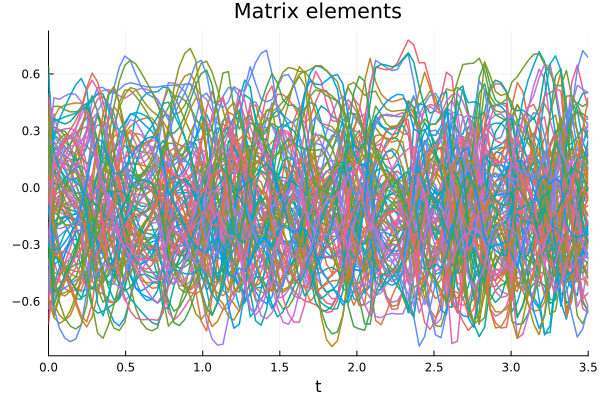

In [8]:
plot(sol, idxs=1:100, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

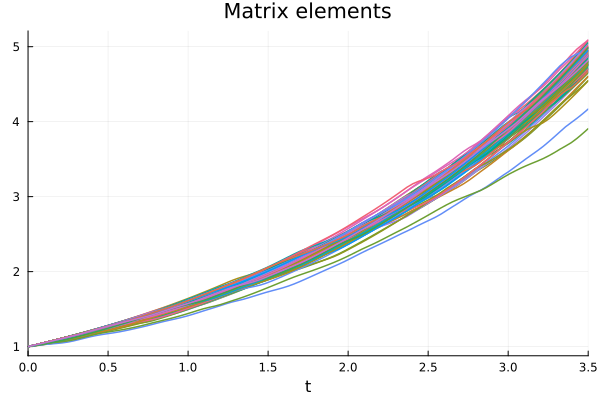

In [9]:
plot(sol, idxs=101:200, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

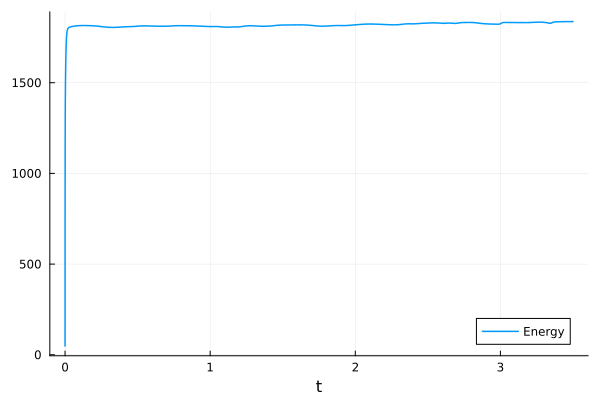

In [16]:
plot(sol.t,[ cost_fnc(reshape(x_t[1:N^2], 10, 10)) for x_t in sol.u] , label="Energy", lw=1.5, xlabel="t")

In [21]:
X = sol.u[end]
P = reshape(X[1:N^2], 10, 10)

P' * P


10×10 Matrix{Float64}:
  1.0081       0.00836831   -0.00206794  …  0.0040903   0.00054499
  0.00836831   1.00849      -0.0026427      0.00384329  0.000230971
 -0.00206794  -0.0026427     1.00856        0.00184945  0.00424333
 -0.00182361  -0.00257342    0.0079262      0.00161462  0.0040204
  0.00195905   0.00196907    0.0020659      0.00201572  0.00150173
  0.00390696   0.00385183    0.00130744  …  0.00278076  0.00146954
  0.00151057   0.00115305    0.00364949     0.00202827  0.00221246
  0.00096151   0.000782926   0.00219451     0.00127888  0.00135306
  0.0040903    0.00384329    0.00184945     1.00288     0.00171406
  0.00054499   0.000230971   0.00424333     0.00171406  1.00228